In [40]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as transforms
import numpy as np

In [56]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# load Mask2Former fine-tuned on ADE20k panoptic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-ade-panoptic")

In [ ]:
json_file = '/mnt/datasets/llava_data/llava_second_stage/llava_v1_5_mix665k.json'
img_dir = '/mnt/datasets/llava_data/llava_second_stage/'

In [ ]:
class PanopticSegmentationDataset(Dataset):
    def __init__(self, json_file, image_path):
        """
        Args:
            json_file (string): Path to the json file.
            img_dir (string): Directory with all the images.
            processor: Directory
        """
        with open(json_file, 'r') as file:
            self.data = json.load(file)
        self.data = [item for item in self.data if ('image' in item) and 'coco' in item['image']]
        self.img_dir = image_path
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converts image to a tensor
            ])
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_id = item["id"]
        image_path = os.path.join(self.img_dir, item["image"])
        image = Image.open(image_path)
        # image = self.transform(image) 
        return {"id": img_id, "image_path": image_path, "image": image}

aux_dataset = PanopticSegmentationDataset(json_file, img_dir)

In [ ]:
def custom_collate_fn(batch):
    batch_ids = [item['id'] for item in batch]
    batch_image_paths = [item['image_path'] for item in batch]
    batch_images = [item['image'] for item in batch]  # Append images as list

    # You can return a dictionary or any other structure that suits your needs
    return {
        'ids': batch_ids,
        'image_paths': batch_image_paths,
        'images': batch_images
    }

In [ ]:
dataset_loader = DataLoader(aux_dataset, 
                                batch_size=4, 
                                num_workers=4,
                                collate_fn=custom_collate_fn)
del aux_dataset

In [ ]:
model.to("cuda")

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                     

In [ ]:
for batch_idx, data_batch in enumerate(dataset_loader):
    print(batch_idx)
    images = data_batch["images"]
    inputs = processor(images, return_tensors="pt")
    inputs = inputs.to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
    # print(images['pixel_values'])
    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits
    if batch_idx == 0:
        break

0


In [ ]:
images_size = [image.size for image in images]

In [ ]:
results = processor.post_process_panoptic_segmentation(outputs, target_sizes = images_size)

`label_ids_to_fuse` unset. No instance will be fused.


In [ ]:
results[0].keys()

dict_keys(['segmentation', 'segments_info'])

In [ ]:
def extract_bounding_box(mask):
    rows, cols = np.where(mask)
    if rows.size > 0 and cols.size > 0:  # Check if there are any True values
        y_min = np.min(rows)
        y_max = np.max(rows)
        x_min = np.min(cols)
        x_max = np.max(cols)
        return (x_min, y_min, x_max, y_max)
    else:
        return None

In [ ]:
for idx, result in enumerate(results):
    segment  =  result['segments_info']
    segment_to_label = {segment['id']: model.config.id2label[segment['label_id']] for segment in result["segments_info"]}
    bbs = {}
    for segment_idx in segment_to_label:
        
        mask = (result['segmentation'].cpu().numpy() == segment_idx)
        bb = extract_bounding_box(mask)
        bbs[segment_idx] = bb
    print(segment_to_label)
    print(bbs)
    print("*"*100)
        

{1: 'bus', 2: 'person', 3: 'truck', 4: 'motorbike', 5: 'motorbike', 6: 'car', 7: 'person', 8: 'car', 9: 'car', 10: 'car', 11: 'car'}
{1: (0, 0, 479, 639), 2: (397, 296, 423, 414), 3: (0, 252, 66, 400), 4: (440, 354, 479, 461), 5: (440, 360, 466, 445), 6: (339, 284, 352, 306), 7: (355, 304, 375, 391), 8: (380, 268, 479, 369), 9: (353, 284, 367, 305), 10: (440, 330, 479, 393), 11: (417, 301, 479, 411)}
****************************************************************************************************
{1: 'sofa', 2: 'cat'}
{1: (0, 0, 382, 639), 2: (240, 325, 266, 423)}
****************************************************************************************************
{1: 'skis', 2: 'person', 3: 'skis', 4: 'person'}
{1: (318, 525, 395, 639), 2: (0, 0, 426, 639), 3: (188, 248, 270, 423), 4: (5, 106, 284, 417)}
****************************************************************************************************
{1: 'dog'}
{1: (0, 0, 499, 374)}
***********************************************

In [ ]:

from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))
        
    ax.legend(handles=handles)


/tmp/ipykernel_1624775/1836790378.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


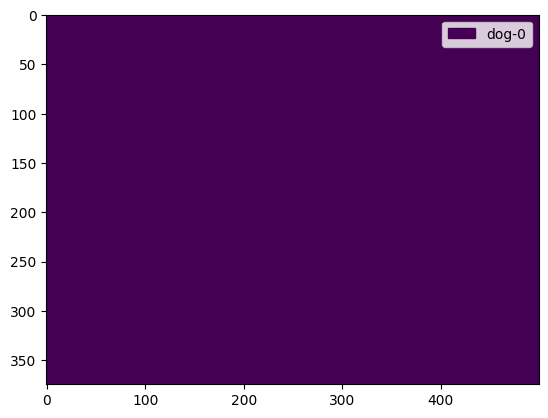

In [ ]:
draw_panoptic_segmentation(result["segmentation"].cpu(), result["segments_info"])

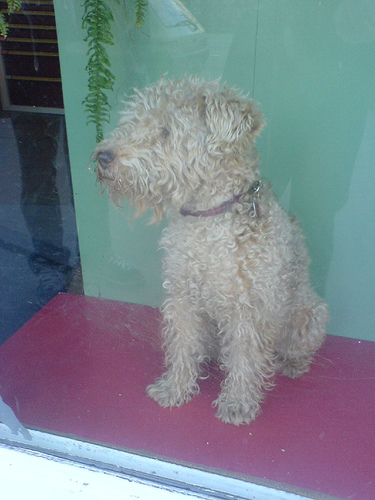

In [ ]:
images[3]